# Shocks in the locally isothermal terminal velocity approximation


In [1]:
#Pkg.add("")
#Pkg.add("PyPlot")
using Plots;
#pgfplots();
pyplot();
#pyplot();

using LaTeXStrings
#options(jupyter.plot_mimetypes = c("text/plain", "image/png" ));
#=
upscale = 1.0 #8x upscaling in resolution
fntsm = Plots.font("sans-serif", 10.0)
fntlg = Plots.font("sans-serif", 12.0)
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
default(size=(800*upscale,600*upscale)) #Plot canvas size
default(dpi=300) #Only for PyPlot - presently broken
=#

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


### Define preshock parameters

In [174]:
const global p₀=50.0;
const global u₀=1.0;
const global c²=4.0;
const global f₀=2.5; #cs^2*(1-f_d), f_d =0.5
const global fd=0.5;
const global ρ₀=p₀/f₀;
const global D=ρ₀*u₀;
const global B=ρ₀*u₀^2+p₀;
global ts=0.1;

### Some useful functions 

In [175]:
Rho(D,u) = D/u;
U(B,D,P) = (B-P)/D
function FD(P,B,D) 
    fd=deepcopy(P)
    uu=deepcopy(P)
    ρρ=deepcopy(P)
    i=1
    for (i,p) ∈ enumerate(P)
        u=U(B,D,p)
        ρ=Rho(D,u)
        fd[i]=1-(p/(c²*ρ))
        uu[i]=u
        ρρ[i]=ρ
    end
    return (fd,uu,ρρ)
end

function ρd(fd::Array{Float64,1}, ρ::Array{Float64,1})
    ρ_d=broadcast(*,ρ,fd)
    return ρ_d
end

integrate_trap(f::Array{Float64,1},h::Float64) = 0.5*h*(f[1]+2.0*sum(f[2:end-1])+f[end])
integrate_simpson(f::Array{Float64,1},h::Float64) = 0.3333333333*h*(f[1]+4.0*sum(f[3:2:end-1])+2.0*sum(f[2:2:end-1])+f[end]) 

integrate_simpson (generic function with 1 method)

### Defining Differential EQN.

In [176]:
∂ₓp(p)=(((p*(B-p))-(p₀*(B-p₀)))/D)/(ts*(c²-(p*((B-p)/(D^2)))));

### Runge-Kutta 4 integrator

In [177]:
K₁(p,h)=h*∂ₓp(p);
K₂(p,h)=h*∂ₓp(p+K₁(p,h)/2);
K₃(p,h)=h*∂ₓp(p+K₂(p,h)/2);
K₄(p,h)=h*∂ₓp(p+K₃(p,h));
p₊₁(p,h)=0.166666666*(K₄(p,h)+2.0K₃(p,h)+2.0K₂(p,h)+K₁(p,h)) +p;

function Integrate(x::Array{Float64},pInit)
    p=pInit;
    P₁=pInit;
    for i=1:49999
        p=p₊₁(p,h);
        P₁=vcat(P₁,p);
    end
    P₋=deepcopy(P₁)
    for i=1:length(P₁)
        P₋[i]=P₁[(length(P₁)-i+1)]
    end
    P₋=map(x->2.0pInit-x,P₋);
    Pn=vcat(P₋,P₁);
    return Pn
end

Integrate (generic function with 1 method)

### Calculating P at shock centre
This is done by setting the right and left states as they are free parameters.

In [178]:

#pInit=0.25*(B-sqrt(1.0+4.0*D^2*f₀)-2.0p₀);
pᵣ=2.0;
pInit=0.5*(p₀+pᵣ);

### running the RK solver
Run for 10000 steps to integrate hals the shock, the solution is then mirrored to produce the other side of the pressure profile.

In [179]:
h=0.0001;
x=map(x->h*x,collect(-50000:49999));
Pn=Integrate(x,pInit);


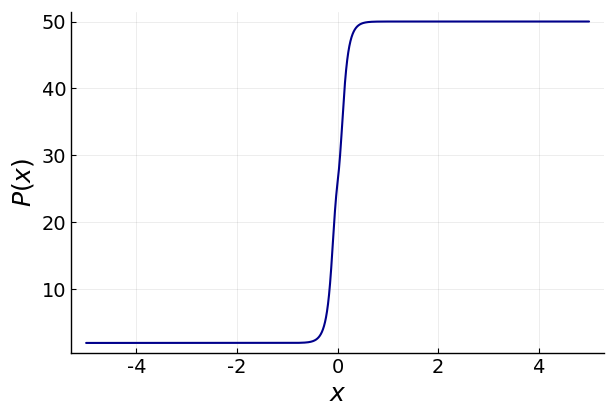

In [180]:
plot(x,Pn,xlabel=L"x",ylabel=L"P(x)",tickfont=font(14),color=:darkblue,guidefont=font(18), legend=false, linewidth=1.5)
savefig("pressureShock.pdf");

In [181]:
Fd=FD(Pn,B,D);

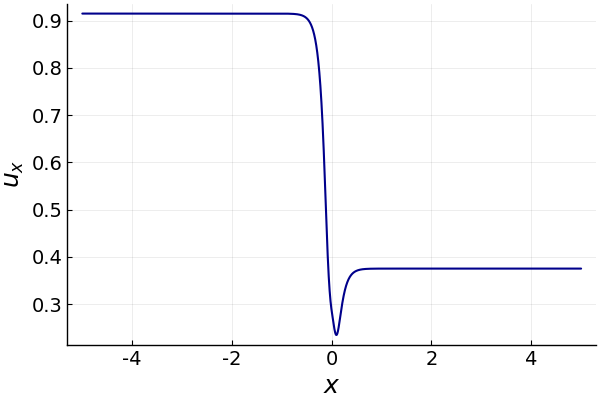

In [246]:
plot(x,Fd[1],xlabel=L"x",ylabel=L"u_x",tickfont=font(14),color=:darkblue,guidefont=font(18), legend=false, linewidth=1.5)
#plot!(x,Fd[2],xlabel="x",ylabel="Y", label="v")
#plot!(x,Fd[3],xlabel="x",ylabel="Y", label="rho")

In [183]:
ρ_d=ρd(Fd[1],Fd[3]);
dust_mass=integrate_simpson(ρ_d,h);
TS=ts;

In [184]:
#This bit is computationally expensive, run only if you need to#
#=
for i=1:10
    ts+=0.05;
    Pn=Integrate(x,pInit);
    Fd=FD(Pn,B,D);
    ρ_d=ρd(Fd[1],Fd[3]);
    dust_mass=vcat(dust_mass,integrate_simpson(ρ_d,h));
    TS=vcat(TS,ts);
end
=#

In [185]:
#plot(log.(TS),dust_mass)
#xlabel!("stopping time")
#ylabel!("dust mass")

# Two fluid stationary shocks
calculating the two fluid shock profile

Integration is done using a simple solver for systems of ODEs. The solver takes an IVP and integrates it using an explicit RK method defined by the user using a Butcher tableau.

In [186]:
push!(LOAD_PATH,".")
using RK

### Defining the ODE

In [239]:
f=0.5;
rho_g0=(1-Fd[1][1])*Fd[3][1];
rho_d0=(Fd[1][1])*Fd[3][1];
println("rho=",rho_g0+rho_d0)
u0=Fd[2][1]
rho_gR=(1-Fd[1][end])*Fd[3][end];
u_gR=Fd[2][end];
u_dR=u_gR;
Bg=rho_g0*u0;
println("Bg0=",Bg)
Bd=rho_d0*u0;
println("Bd0=",Bd)
d=rho_g0*(u0^2+c²)+rho_d0*(u0^2);
println("D0=",d)
yDash(x,y)=-(Bd/ts)*((y[1]^2)*(Bd*Bg-d*y[1]+Bg^2+c²*y[1]^2))/((d*y[1]-Bg^2-c²*(y[1]^2)+Bd^2)*(y[1]^2*c²-Bg^2))
println("y'=",yDash(0,rho_g0))
problem=[yDash]
trange=0.0001:0.0001:5
init=[rho_gR]
ivp=ivpSystem(problem,init)

rho=5.882352941176778
Bg0=1.7000000000029303
Bd0=18.29999999999707
D0=70.0
y'=-2.937097948744269e-17


ivpSystem(Function[yDash], [12.5])

In [240]:
Sol=integrateRK(ivp,trange,rk4)

Dict{String,Array{Float64,N} where N} with 2 entries:
  "t" => [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.000…
  "y" => [12.5 12.5017 … 17.0 17.0]

In [241]:
ynew=zeros(length(Sol["y"][1,:]));
ynew=ynew.+rho_g0;
ynew=vcat(ynew,Sol["y"][1,:]);

In [242]:
ug=Bg./ynew;
ud=(d.-ynew.*(ug.^2 .+c²))./Bd;
rhod=Bd./ud;
u=(rhod.*ud)./(rhod.+ynew) .+ (ynew.*ug)./(rhod.+ynew);
rho=rhod+ynew;

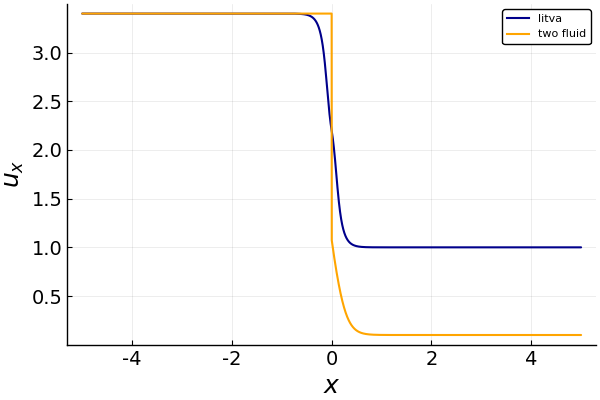

In [245]:
plot(x,Fd[2],xlabel=L"x",ylabel=L"u_x",tickfont=font(14),color=:darkblue,guidefont=font(18), linewidth=1.5,label="litva")
plot!(x,ud,xlabel=L"x",ylabel=L"u_x",tickfont=font(14),color=:orange,guidefont=font(18), linewidth=1.5, label="two fluid")

In [247]:
ug[end]-ud[end]

-4.547195953108485e-13